# ROMY & FUR

## Load Libraries

In [1]:
import os, sys
import pickle
import matplotlib.pyplot as plt
import numpy as np

from obspy import UTCDateTime, read_inventory
from scipy.signal import welch

from functions.get_fband_average import __get_fband_average
from functions.get_median_psd import __get_median_psd

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [3]:
from andbro__read_sds import __read_sds

In [4]:
## ---------------------------------------

config = {}


config['station1'] = "BW.ROMY.10.BJZ"
config['station2'] = "GR.FUR..BHN"

config['tbeg'] = UTCDateTime("2023-09-23 01:00")

config['tend'] = UTCDateTime("2023-09-23 02:00")

config['path_to_sds1'] = archive_path+"romy_archive/"
config['path_to_sds2'] = bay_path+f"mseed_online/archive/"

config['path_to_figures'] = data_path+f"VelocityChanges/figures/"

config['path_to_inv'] = root_path+"Documents/ROMY/stationxml_ringlaser/"

In [5]:
inv1 = read_inventory(config['path_to_inv']+"dataless.seed.BW_ROMY")
inv2 = read_inventory(config['path_to_inv']+"dataless.seed.GR_FUR")

In [6]:
st1 = __read_sds(config['path_to_sds1'], config['station1'], config['tbeg'], config['tend']);
st2 = __read_sds(config['path_to_sds2'], config['station2'], config['tbeg'], config['tend']);
st2 += __read_sds(config['path_to_sds2'], "GR.FUR..BHE", config['tbeg'], config['tend']);

st1.remove_sensitivity(inv1);
st2.remove_response(inv2, output="ACC", water_level=10);

In [7]:
st1.detrend("linear");
st2.detrend("linear");

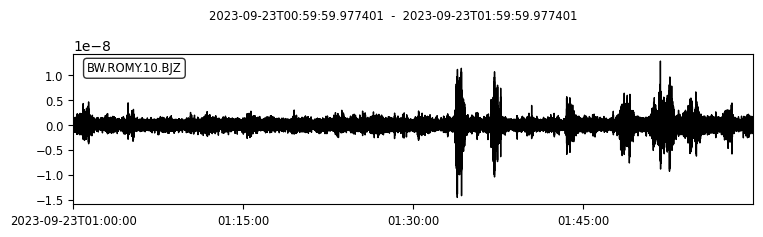

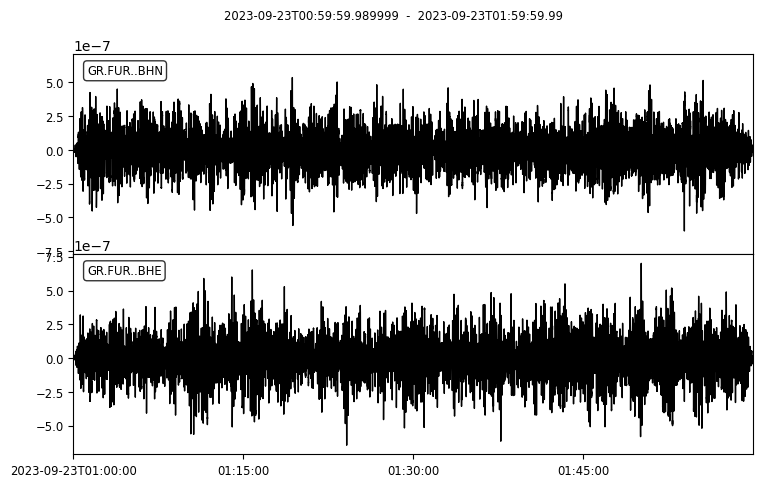

In [8]:
st1.plot();
st2.plot();

## Cross Wavelet Transform

In [9]:
from functions.get_xwt import __compute_cross_wavelet_transform

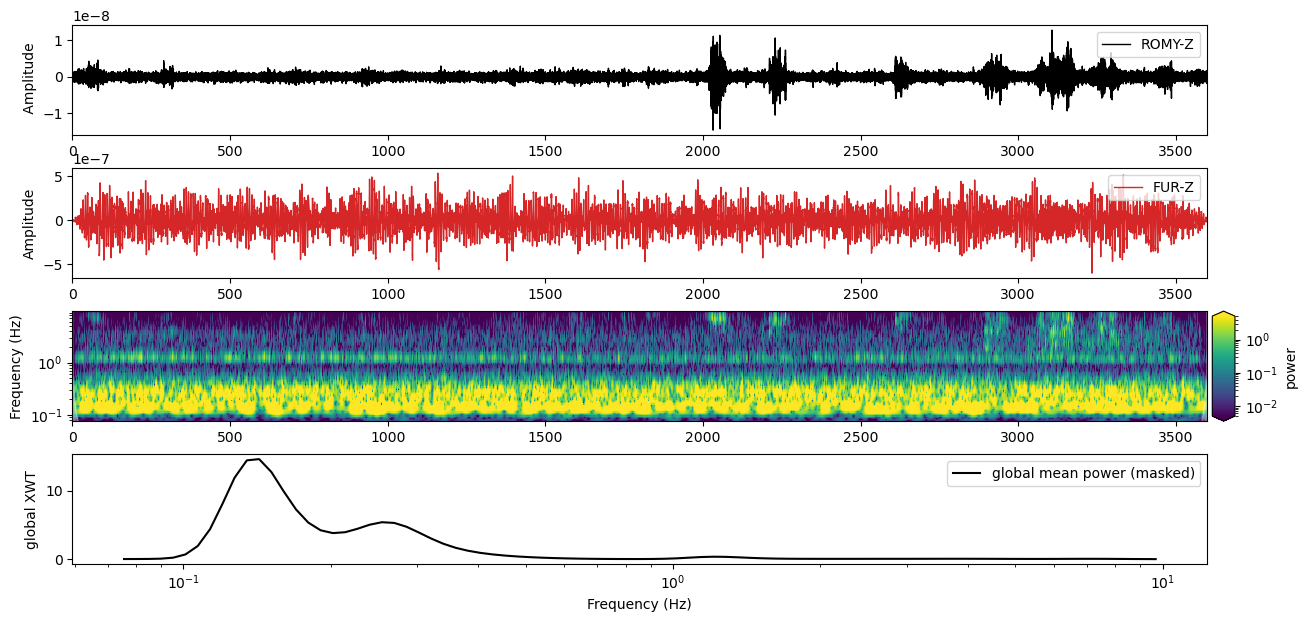

In [10]:
tt = st1[0].times()

dt = st1[0].stats.delta

dat1 = st1[0].data
dat2 = st2[0].data

out = __compute_cross_wavelet_transform(tt, dat1, dat2, dt,
                                        datalabels=["ROMY-Z", "FUR-Z"],
                                        xscale="log",
                                        cmap_scale="log",
                                        plot=True,
                                       )

out['fig'].savefig(config['path_to_figures']+f"Waveforms_FUR_ROMY_XWT_{config['tbeg'].date}.png", format="png", dpi=150, bbox_inches='tight')


In [11]:
def __compute_backazimuth(st_acc, st_rot, config, wave_type="love", flim=(None, None), event=None, plot=True, show_details=False):

    """
    This method estimates a backazimuth for either
     - Love waves (vertical rotation rate and transverse acceleration) or
     - Rayleigh waves (vertical acceleration and transverse rotation rate)
    and compares it to a theoretical backazimuth computed from the source and receiver location.


    ARGUMENTS:

    - st_rot:  stream of rotation rate (ideally 3 components with channels *Z,*N,*E)
    - config:  configuration parameters as dictionary. Keywords:
               'tbeg','tend','station_latitude', 'station_longitude', 'step', 'win_length_sec', 'overlap', 'eventtime'
    - wave_type:  "love" or "rayleigh" (default: "love")
    - event:  event obspy object. Default is None. If None USGS catalog is searched for appropriate event.
    - plot:   bool (default: True). Shows plot if set True
    - show_details:  bool (default: False). Shows messages while executing if set True.

    RETURN:
    - out:  dictionary with output data. Keywords:
            'baz_mesh', 'baz_corr', 'baz_theo', 'acc_transverse', 'acc_radial', 'rot_vertical', 'event'

    >>> out = __compute_backazimuth(st_acc, st_rot, config, wave_type="love", event=None, plot=True, show_details=False)

    """

    import matplotlib as mpl
    import matplotlib.pyplot as plt

    from numpy import ones, arange, linspace, asarray, array, meshgrid, round, shape
    from pprint import pprint
    from obspy import read, read_events, UTCDateTime
    from obspy.clients.fdsn import Client
    from obspy.geodetics.base import gps2dist_azimuth
    from obspy.signal.cross_correlation import correlate, xcorr_max
    from obspy.signal.rotate import rotate_ne_rt

    ## _______________________________
    ## check config
    keywords=['tbeg','tend','station_latitude', 'station_longitude',
              'step', 'win_length_sec', 'overlap', 'eventtime']

    for key in keywords:
        if key not in config.keys():
            print(f" -> {key} is missing in config!\n")
            pprint(keywords)
            return


    ## _______________________________
    ## Defaults
    if 'win_length_sec' not in config.keys():
        config['win_length_sec'] = .5    ## window length for correlation
    if 'step' not in config.keys():
        config['step'] = 1
    if 'overlap' not in config.keys():
        config['overlap'] = 25


    ## time period
    config['tbeg'], config['tend'] = UTCDateTime(config['tbeg']), UTCDateTime(config['tend'])
    config['eventime'] = UTCDateTime(config['eventtime'])

    ## _______________________________
    ## prepare streams
    if wave_type == "love":
        ACC = st_acc.copy().trim(config['tbeg'], config['tend'])
        ROT = st_rot.copy().trim(config['tbeg'], config['tend'])

        ## revert polarity for Z
        # for tr in ROT:
        #     if "Z" in tr.stats.channel:
        #         tr.data *= -1

    elif wave_type == "rayleigh":
        ACC = st_acc.copy().trim(config['tbeg'], config['tend'])
        ROT = st_rot.copy().trim(config['tbeg'], config['tend'])

    ## _______________________________
    ## get event if not provided
    if event == "auto":
        try:
            events = Client("USGS").get_events(starttime=config['eventtime']-20, endtime=config['eventtime']+20)
            if len(events) > 1:
                print(f" -> {len(events)} events found!!!")
                print(events)
                event = events[0]
        except:
            print(" -> no event found in USGS catalog")


    ## event location from event info
    if event is not None:
        config['source_latitude'] = event.origins[0].latitude
        config['source_longitude'] = event.origins[0].longitude

        if show_details:
            print(" -> event used for theoretical backazimuth:")
            print(" -> ", event.event_descriptions[0]['type'], ': ',event.event_descriptions[0]['text'] + "\n")


        ## _______________________________
        ## theoretical backazimuth and distance

        config['baz'] = gps2dist_azimuth(
                                        config['source_latitude'], config['source_longitude'],
                                        config['station_latitude'], config['station_longitude'],
                                        )
        if show_details:
            print(f" -> Epicentral distance [m]:       {round(config['baz'][0],1)}")
            print(f" -> Theoretical azimuth [deg]:     {round(config['baz'][1],1)}")
            print(f" -> Theoretical backazimuth [deg]: {round(config['baz'][2],1)}")

    ## _______________________________
    ## backazimuth estimation with Love or Rayleigh waves

    config['sampling_rate'] = int(ROT.select(channel="*Z")[0].stats.sampling_rate)

    config['num_windows'] = len(ROT.select(channel="*Z")[0]) // (int(config['sampling_rate'] * config['win_length_sec']))

    backas = linspace(0, 360 - config['step'], int(360 / config['step']))

    corrbaz = []

    ind = None

    config['num_windows']

    for i_deg in range(0, len(backas)):

        for i_win in range(0, config['num_windows']):

            ## infer indices
            idx1 = int(config['sampling_rate'] * config['win_length_sec'] * i_win)
            idx2 = int(config['sampling_rate'] * config['win_length_sec'] * (i_win + 1))

            ## add overlap
            if i_win > 0 and i_win < config['num_windows']:
                idx1 = int(idx1 - config['overlap']/100 * config['win_length_sec'] * config['sampling_rate'])
                idx2 = int(idx2 + config['overlap']/100 * config['win_length_sec'] * config['sampling_rate'])

            ## prepare traces according to selected wave type
            if wave_type == "love":

                if show_details and i_deg == 0 and i_win == 0:
                    print(f"\n -> using {wave_type} waves for estimation ...")

                ## rotate NE to RT
                R, T = rotate_ne_rt(ACC.select(channel='*N')[0].data,
                                    ACC.select(channel='*E')[0].data,
                                    backas[i_deg]
                                   )

                ## compute correlation for backazimuth
#                 corrbaz0 = xcorr(ROT.select(channel="*Z")[0][idx1:idx2], T[idx1:idx2], 0,)
                ccorr = correlate(ROT.select(channel="*Z")[0][idx1:idx2], T[idx1:idx2], 0,
                                  demean=True, normalize='naive', method='fft')
                xshift, cc_max = xcorr_max(ccorr)

                if xshift != 0:
                    print(f" -> maximal cc not a shift=0: shift={xshift} | cc={cc_max}")

            elif wave_type == "rayleigh":

                if show_details and i_deg == 0 and i_win == 0:
                    print(f"\n -> using {wave_type} waves for estimation ...")

                ## rotate NE to RT
                R, T = rotate_ne_rt(ROT.select(channel='*N')[0].data,
                                    ROT.select(channel='*E')[0].data,
                                    backas[i_deg]
                                   )

                ## compute correlation for backazimuth
                ## vertical acceleration has to be reversed for definition of polarization reasons
                ccorr = correlate(-1*ACC.select(channel="*Z")[0][idx1:idx2], T[idx1:idx2], 0,
                                  demean=True, normalize='naive', method='fft')
#                 ccorr = correlate(ACC.select(channel="*Z")[0][idx1:idx2], T[idx1:idx2], 0,
#                                   demean=True, normalize='naive', method='fft')

                xshift, cc_max = xcorr_max(ccorr)

                if xshift != 0:
                    print(f" -> maximal cc not a shift=0: shift={xshift} | cc={cc_max}")

            else:
                print(f" -> unknown mode {wave_type}!")

            corrbaz.append(cc_max)


    corrbaz = asarray(corrbaz)
    corrbaz = corrbaz.reshape(len(backas), config['num_windows'])


    ## extract maxima
    maxcorr = array([backas[corrbaz[:, l1].argmax()] for l1 in range(0, config['num_windows'])])
    maxcorr_value = array([max(corrbaz[:, l1]) for l1 in range(0, config['num_windows'])])

    ## create mesh grid
    t_win = arange(0, config['win_length_sec']*config['num_windows']+config['win_length_sec'], config['win_length_sec'])
    t_win_center = t_win[:-1]+config['win_length_sec']/2
    mesh = meshgrid(t_win, backas)



    ## _______________________________
    ## Plotting
    def __makeplot():

        ## define figure
        fig, ax = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

        plt.subplots_adjust(hspace=0.1)

        ## parameters
        font = 12

        acc_scaling, acc_unit = 1e3, "mm/s$^2$"
        rot_scaling, rot_unit = 1e6, r"$\mu$rad/s"

        ## create time axis
        time = linspace(0, len(ACC[0].data)/ACC[0].stats.sampling_rate, len(ACC[0].data))

        ## plot vertical rotation rate
        if wave_type == "love":
            ax[0].plot(time, ROT.select(channel="*Z")[0].data*rot_scaling, label='vertical rotation rate')
            ax[0].set_ylabel(f'vert. rot. rate \n({rot_unit})', fontsize=font)
        elif wave_type == "rayleigh":
            ax[0].plot(time, T*rot_scaling, label='transverse rotation rate')
            ax[0].set_ylabel(f'trans. rot. rate \n({rot_unit})', fontsize=font)


        ## plot transverse acceleration
        if wave_type == "love":
            ax[1].plot(time, T*acc_scaling, 'k',label='transverse acceleration')
            ax[1].set_ylabel(f'transv. acc. \n({acc_unit})', fontsize=font)
        elif wave_type == "rayleigh":
            ax[1].plot(time, ACC.select(channel="*Z")[0].data*acc_scaling, 'k',label='vertical acceleration')
            ax[1].set_ylabel(f'vert. acc. \n({acc_unit})', fontsize=font)


        ## backazimuth estimation plot
        im = ax[2].pcolormesh(t_win, backas, corrbaz[:-1,:], cmap=plt.cm.RdYlGn_r, vmin=-1, vmax=1, shading='auto')

#         ax[2].set_xlim(time[0], time[-1])
        ax[2].set_xlim(t_win[0], t_win[-1])
        ax[2].set_ylim(0, 360)
        ax[2].set_ylabel(u'estimated \n backazimuth (°)', fontsize=font)
        ax[2].set_xlabel('time (s)', fontsize=font)


        ## plot maximal correclation values
        ax[2].plot(t_win_center, maxcorr, '.k')


        if event is not None:
            ## plot theoretical Backazimuth for comparison
            xx = arange(0, config['win_length_sec'] * len(maxcorr) + 1, config['win_length_sec'])
            tba = ones(len(xx)) * config['baz'][2]
            ax[2].plot(xx, tba, lw=1.5, alpha=0.7, color="k", ls="--")


            ## add label for theoretical backazimuth
            baz_label = u'Theor. BAZ = '+str(round(config['baz'][2],0))+'°'
            if config['baz'][2] < 330:
                x_text, y_text = time[int(0.78*len(time))], config['baz'][2]+5
            else:
                x_text, y_text = time[int(0.78*len(time))], config['baz'][2]-15
                ax[2].text(x_text, y_text, baz_label, color='k', fontsize=font-2)


            ## epicentral distance
            edist = round(config['baz'][0]/1000, 1)


        ## adjust title
        date = config['tbeg'].date
        t1, t2 = str(config['tbeg'].time).split(".")[0], str(config['tend'].time).split(".")[0]
        try:
            if flim[0] is not None and flim[1] is not None:
                ax[0].set_title(f" {date} | {t1} - {t2} UTC | Epicentral Distance = {edist} km | {flim[0]}-{flim[1]} Hz", fontsize=font-1)
            else:
                ax[0].set_title(f" {date} | {t1} - {t2} UTC | Epicentral Distance = {edist} km", fontsize=font-1)
        except:
            try:
                ax[0].set_title(f" {date} | {t1} - {t2} UTC | Twin = {config['win_length_sec']} s | {flim[0]}-{flim[1]} Hz | {round(1/flim[1], 1)}-{round(1/flim[0],1)} s", fontsize=font-1)
            except:
                ax[0].set_title(f" {date} | {t1} - {t2} UTC", fontsize=font-1)

        ## tune tick size
        for i in range(3):
            ax[i].tick_params(axis="y", labelsize=font-1)
            ax[i].tick_params(axis="x", labelsize=font-1)
            ax[i].set_xlim(time[0], time[-1])

        ## add legends
        ax[0].legend(loc=1, fontsize=font-2)
        ax[1].legend(loc=1, fontsize=font-2)

        ## adjust tick label style
        ax[1].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))


        ## add colorbar
        cax = ax[2].inset_axes([1.01, 0., 0.02, 1])
        cb1 = plt.colorbar(im, ax=ax[2], cax=cax)
        cb1.set_label("CC Coefficient", fontsize=font)

        plt.show();
        return fig

    if plot:
        fig = __makeplot();


    ## _______________________________
    ## prepare output

    output = {}

    output['baz_mesh'] = mesh
    output['baz_corr'] = corrbaz
    output['acc'] = ACC
    output['rot'] = ROT
    output['event'] = event
    output['cc_max_t'] = t_win_center
    output['cc_max_y'] = maxcorr
    output['cc_max'] = maxcorr_value

    if event is not None:
        output['baz_theo'] = config['baz'][2]

    if plot:
        output['fig'] = fig

    return output

## End of File

In [12]:
acc = st2.copy();
rot = st1.copy();

fmin, fmax = 1/10, 1/8
fmin, fmax = 1/10, 1/8

acc = acc.detrend("linear");
acc = acc.taper(0.01);
acc = acc.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=8, zerophase=True);

rot = rot.detrend("linear");
rot = rot.taper(0.01);
rot = rot.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=8, zerophase=True);

In [13]:
conf = {}

conf['eventtime'] = config['tbeg']

conf['tbeg'] = config['tbeg']
conf['tend'] = config['tend']

conf['station_longitude'] = 11.275501
conf['station_latitude']  = 48.162941

## specify window length for baz estimation in seconds
conf['win_length_sec'] = 5/fmin

## define an overlap for the windows in percent (50 -> 50%)
conf['overlap'] = 50

## specify steps for degrees of baz
conf['step'] = 1

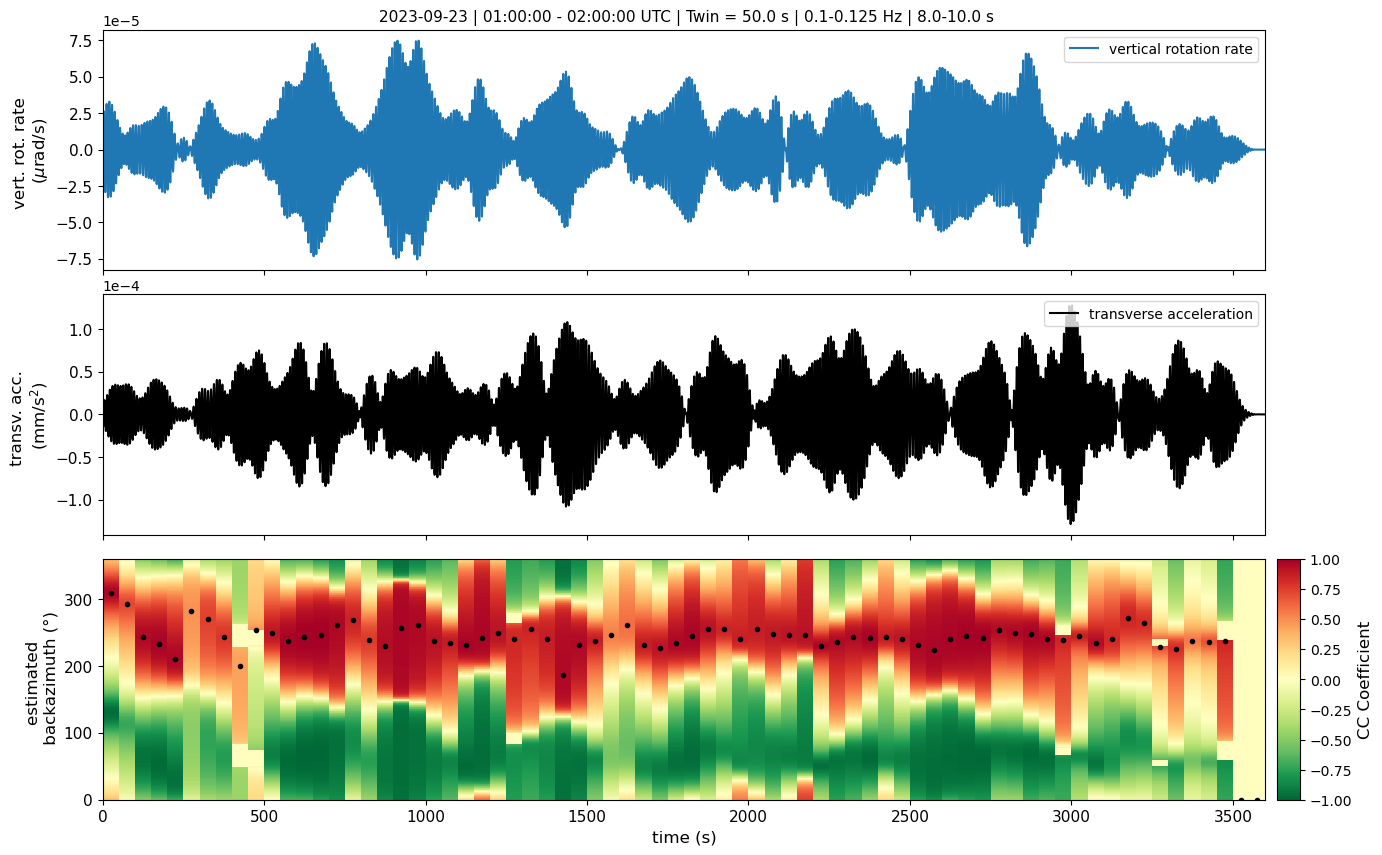

In [14]:
out = __compute_backazimuth(
                            acc,
                            rot,
                            conf,
                            wave_type='love',
                            event=None,
                            plot=True,
                            flim=(fmin, fmax),
                            show_details=False,
                            )

out['fig'].savefig(config['path_to_figures']+f"Waveforms_FUR_ROMY_BAZ_{config['tbeg'].date}.png", format="png", dpi=150, bbox_inches='tight')


In [15]:
1/(1/8)

8.0